# Relationship of personality traits with the probability of being employed in Poland

## Abstract

The current challenges of the labour market require a thorough analysis of factors related to the probability of employment of individuals. This paper presents the most important theories related to the labour market, such as the Search and Matching Theory, the Human Capital Theory and the Statistical Discrimination Theory. The Big Five Theory was also introduced and empirical research on the relationship between personality and employability was analyzed. In the research part, based on the data from the PIAAC and post-PIAAC studies, logit models were estimated, aimed at examining the relationship of personality traits with the probability of employment. The results showed that differences in respondents' personalities were related to the probability of employment.

In [297]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import warnings
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
import plotly.express as px


## Data

The analysis was performed based on individual-derived data
from the PIAAC (Programme for the International Assessment of Adult Competencies) for Poland, as well as its national follow-up (post-PIAAC), in which additional information was collected from people participating in the first edition of the study. This data was chosen because it is the only study on the situation of Poles in the labor market that provides not only information about the cognitive skills of respondents, but also their personality traits.

The relationship of personality traits with the probability of employment was estimated using logit model in which the dependent variable is discrete and takes the value of 1 in the case of taking up employment during the post-PIAAC study period and 0 in the case of remaining unemployed or professionally inactive during that period. It was decided to use the logit model because for the purposes of this study, it was important to compare the model with the results of other studies conducted in other countries.

In [203]:
data = pd.read_stata("C:\piaac_study.dta")

selected_data = data[["sq", "eq", "uq", "iq", "nq", "age_r", "age_r2", "gender_r", "edu_lvl2", "train_all", "employ"]]

with warnings.catch_warnings():
     warnings.filterwarnings('ignore')

The dataset includes 4967 rows and 11 columns.

In [204]:
selected_data.shape

(4967, 11)

In [205]:
selected_data.head(5)

,sq,eq,uq,iq,nq,age_r,age_r2,gender_r,edu_lvl2,train_all,employ
0,5.666667,3.333333,6.000000,3.666667,4.666667,23.0,529.0,Male,3.0,2.0,1.0
1,7.000000,4.000000,4.000000,4.000000,4.000000,33.0,1089.0,Male,2.0,0.0,1.0
2,5.000000,2.000000,3.333333,4.333333,3.666667,19.0,361.0,Male,3.0,2.0,1.0
3,6.000000,2.666667,4.000000,3.333333,3.666667,20.0,400.0,Female,4.0,0.0,0.0
4,7.000000,5.000000,6.333333,5.333333,2.333333,19.0,361.0,Male,3.0,0.0,1.0


In [206]:
selected_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4967 entries, 0 to 4966
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   sq         4731 non-null   float32 
 1   eq         4694 non-null   float32 
 2   uq         4720 non-null   float32 
 3   iq         4663 non-null   float32 
 4   nq         4705 non-null   float32 
 5   age_r      4967 non-null   category
 6   age_r2     4967 non-null   float32 
 7   gender_r   4967 non-null   category
 8   edu_lvl2   4967 non-null   float32 
 9   train_all  4967 non-null   float32 
 10  employ     4967 non-null   float32 
dtypes: category(2), float32(9)
memory usage: 225.7 KB


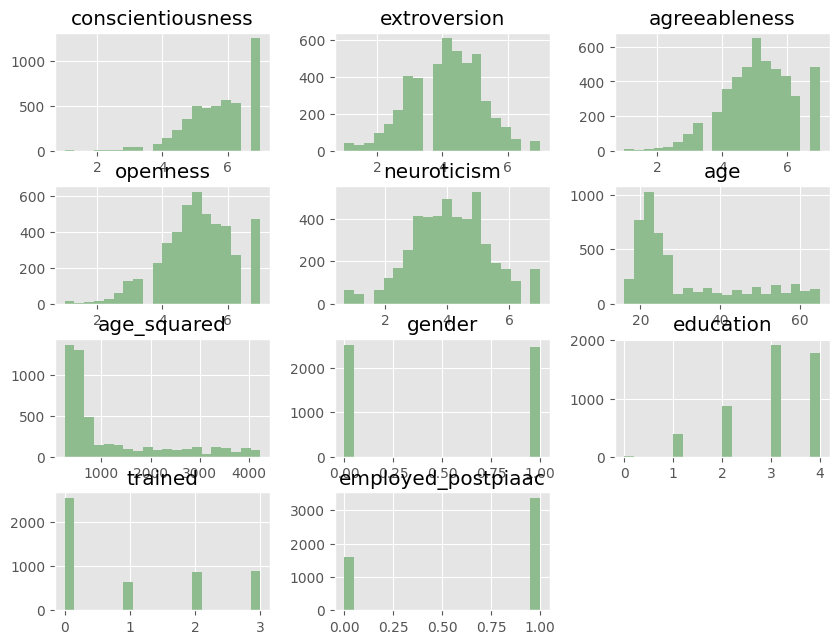

In [385]:
selected_data.hist(bins=20, figsize=(10,7.5), color="darkseagreen")
plt.show()

## Data Cleaning

In [208]:
selected_data = selected_data.rename(columns = {"sq": "conscientiousness",
                                "eq": "extroversion", 
                                "uq": "agreeableness" , 
                                "iq": "openness",
                                "nq": "neuroticism",
                                "age_r": "age",
                                "age_r2": "age_squared",
                                "gender_r": "gender",
                                "edu_lvl2": "education",
                                "train_all": "trained",
                                "employ": "employed_postpiaac"})

Perform label-encoding for categorical variables:

In [209]:
le = LabelEncoder()

for cat_var in ["gender", "education", "trained", "employed_postpiaac"]:
    selected_data[cat_var] = le.fit_transform(selected_data[cat_var])  

In [210]:
cols = ["age", "age_squared"]
selected_data[cols] = selected_data[cols].applymap(np.int64)

In [211]:
selected_data = selected_data[::].round(decimals = 1)

In [212]:
selected_data.head(10)

,conscientiousness,extroversion,agreeableness,openness,neuroticism,age,age_squared,gender,education,trained,employed_postpiaac
0,5.7,3.3,6.0,3.7,4.7,23,529,1,3,2,1
1,7.0,4.0,4.0,4.0,4.0,33,1089,1,2,0,1
2,5.0,2.0,3.3,4.3,3.7,19,361,1,3,2,1
3,6.0,2.7,4.0,3.3,3.7,20,400,0,4,0,0
4,7.0,5.0,6.3,5.3,2.3,19,361,1,3,0,1
5,5.3,5.0,4.3,5.7,3.7,22,484,1,4,1,1
6,7.0,6.7,4.7,7.0,3.7,23,529,0,4,0,1
7,7.0,3.7,6.3,6.7,5.3,34,1156,1,3,0,1
8,5.0,4.3,3.0,4.7,4.7,25,625,1,4,0,1
9,5.7,3.7,4.7,5.7,3.7,23,529,1,1,2,1


Find missing values:

In [213]:
selected_data.isna().values.any()

True

In [214]:
selected_data.isna().sum()

conscientiousness     236
extroversion          273
agreeableness         247
openness              304
neuroticism           262
age                     0
age_squared             0
gender                  0
education               0
trained                 0
employed_postpiaac      0
dtype: int64

As the analyzed sample is relatively small and the missing data are present for variables related to the personality traits, in order not to lose too much information, it was decided to use the imputation method for replacing missing data. 

In [216]:
imputer = SimpleImputer(strategy="median")

In [218]:
imputer.fit(selected_data)

SimpleImputer(strategy='median')

In [219]:
X = imputer.transform(selected_data)

As a result of the transformation, the NumPy array was obtained, which was then placed in the DataFrame object:

In [220]:
clean_data = pd.DataFrame(X, columns = selected_data.columns, index = selected_data.index)

## Exploratory Data Analysis

### Univariate analysis

Firstly, let's delve into summary statistics of the data:

In [223]:
clean_data.describe()

,conscientiousness,extroversion,agreeableness,openness,neuroticism,age,age_squared,gender,education,trained,employed_postpiaac
count,4967.000000,4967.000000,4967.000000,4967.000000,4967.000000,4967.000000,4967.000000,4967.000000,4967.000000,4967.000000,4967.000000
mean,5.718442,4.077834,5.072861,5.042420,4.106724,31.557681,1192.990739,0.494262,3.017314,1.025166,0.677874
std,0.970627,1.066112,1.066115,1.074803,1.242457,14.040770,1099.128650,0.500017,0.931668,1.187925,0.467338
min,1.000000,1.000000,1.000000,1.000000,0.700000,16.000000,256.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,3.300000,4.300000,4.300000,3.300000,21.000000,441.000000,0.000000,2.000000,0.000000,0.000000
50%,5.700000,4.000000,5.000000,5.000000,4.000000,25.000000,625.000000,0.000000,3.000000,0.000000,1.000000
75%,6.700000,4.700000,5.700000,5.700000,5.000000,41.000000,1681.000000,1.000000,4.000000,2.000000,1.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,65.000000,4225.000000,1.000000,4.000000,3.000000,1.000000


Personality traits were measured based on 7-point Linert scale, thus it's not possible to have a minimum value of 0.7 in the neuroticism column.

In [225]:
clean_data[clean_data.neuroticism < 1]

,conscientiousness,extroversion,agreeableness,openness,neuroticism,age,age_squared,gender,education,trained,employed_postpiaac
1588,5.7,5.0,5.0,3.0,0.7,24.0,576.0,1.0,1.0,0.0,0.0


In [230]:
neuroticism_outlier = clean_data[clean_data.neuroticism < 1]
clean_data.drop(neuroticism_outlier.index, inplace = True)

#### Personality Traits

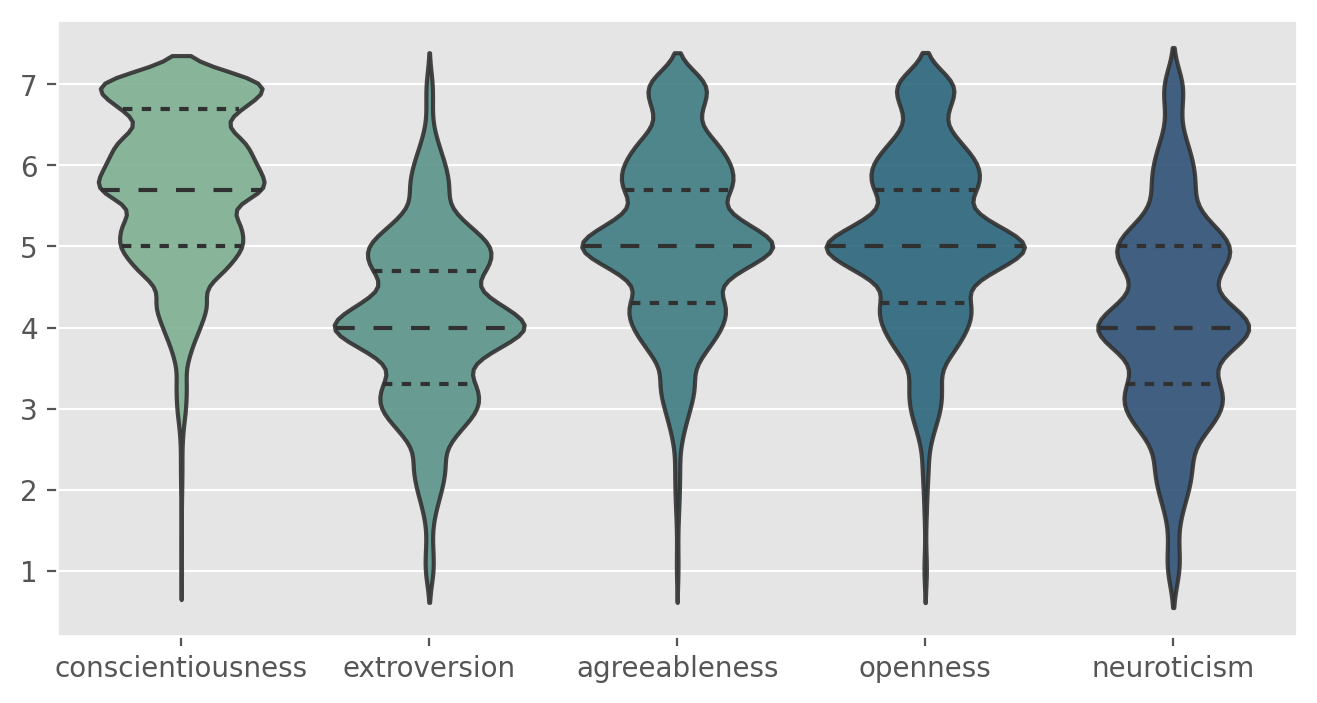

In [390]:
plt.figure(figsize=(8,4), dpi=200)

ax = sns.violinplot(
       data = clean_data[['conscientiousness', 'extroversion', 'agreeableness', 'openness',
       'neuroticism']],
       palette = "crest", 
       inner = "quartile")

plt.setp(ax.collections, alpha=.9)

plt.show()


The results of the personality test on the larger sample should form a normal distribution. As can be seen from the graphs, the probability density distributions for extraversion and neuroticism are close to a normal distribution, while for the traits conscientiousness, agreeableness and openness, a left skewness of the distributions was observed. 
In the case of conscientiousness, the leftward skewness is confirmed in the literature and is due to the fact that respondents often tend to give answers that are more socially desirable in relation to this trait.  


The greater accumulation of values ​​around the median results from the imputation method used in the earlier stage of the analysis.


#### Age

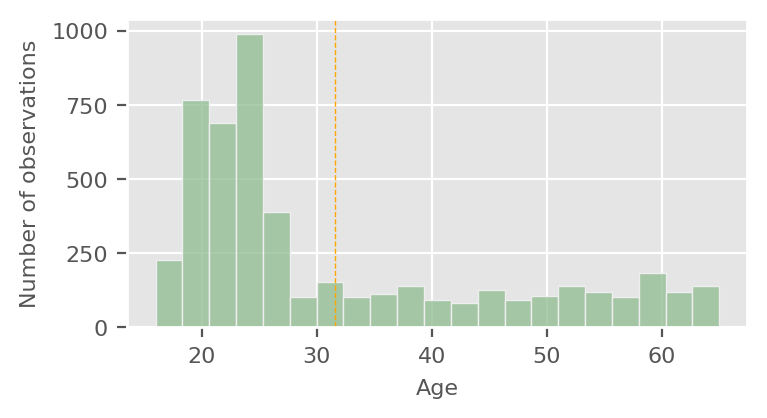

In [379]:
plt.figure(figsize=(4,2), dpi=200)
plt.style.use('ggplot')

ax = sns.histplot(
       data = clean_data["age"],
       color = "darkseagreen")

ax.axvline(x=clean_data.age.mean(),
            color='orange',
            linestyle = '--',
            linewidth = 0.5)

ax.set_xlabel("Age", fontsize = 8)
ax.set_ylabel("Number of observations", fontsize = 8)

plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

plt.show()

The average age was 31. It should be noted that the Polish study chose to over-represent young people aged 19-26, the purpose of which was to enable a detailed analysis between young people's competences and educational and professional pathways.

#### Gender

In [338]:
tab = pd.crosstab(index=clean_data['gender'], columns='count')
tab/tab.sum()

col_0,count
gender,
0.0,0.50584
1.0,0.49416


Gender was evenly distributed in the given sample.

#### Education

In [331]:
tab = pd.crosstab(index=clean_data['education'], columns='count')
tab/tab.sum()

col_0,count
education,
0.0,0.002618
1.0,0.077527
2.0,0.176601
3.0,0.386025
4.0,0.357229


The majority of respondents had a secondary or post-secondary education (38%) or a higher education - bachelor's or master's degree (35%). About 18% of respondents had a basic vocational education. 

#### Trainings

In [332]:
tab = pd.crosstab(index=clean_data['trained'], columns='count')
tab/tab.sum()

col_0,count
trained,
0.0,0.512284
1.0,0.130890
2.0,0.175997
3.0,0.180830


More than 50% of respondents had not received any training in the two years preceding the PIAAC and postPIAAC survey. 

#### Employment status during postPIAAC study

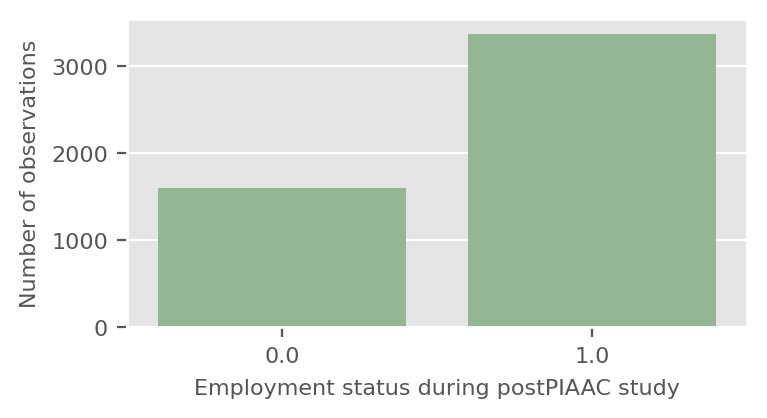

In [373]:
plt.figure(figsize=(4,2), dpi=200)
plt.style.use('ggplot')

ax = sns.countplot(
       data = clean_data,
       x = "employed_postpiaac",
       color = "darkseagreen")

ax.set_xlabel("Employment status during postPIAAC study", fontsize = 8)
ax.set_ylabel("Number of observations", fontsize = 8)

plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

plt.show()

From the above chart we can observe that there is a class imbalance, which will be addressed at a later stage of this analysis.

### Bivariate analysis

In [367]:
# Fill diagonal and upper half with NaNs
# https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

corr = clean_data.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

,conscientiousness,extroversion,agreeableness,openness,neuroticism,age,age_squared,gender,education,trained,employed_postpiaac
conscientiousness,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
extroversion,0.02,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
agreeableness,0.31,0.02,nan,nan,nan,nan,nan,nan,nan,nan,nan
openness,0.19,0.24,0.11,nan,nan,nan,nan,nan,nan,nan,nan
neuroticism,-0.08,0.03,-0.14,-0.04,nan,nan,nan,nan,nan,nan,nan
age,0.12,-0.07,0.12,-0.03,0.05,nan,nan,nan,nan,nan,nan
age_squared,0.10,-0.07,0.11,-0.04,0.06,0.99,nan,nan,nan,nan,nan
gender,-0.11,-0.07,-0.13,-0.05,-0.22,-0.05,-0.05,nan,nan,nan,nan
education,0.01,0.05,-0.04,0.12,-0.02,-0.26,-0.27,-0.17,nan,nan,nan
trained,0.04,0.06,-0.04,0.13,-0.09,-0.20,-0.22,0.02,0.36,nan,nan


Relatively strong correlations were observed between variables representing human capital - more specifically between `education` and `trained`, which may indicate that better educated people were more likely to have participated in trainings. 
As for the outcome variable, `trained` was the most strongly correlated variable. 

Among the Big Five characteristics, the variables `conscientiousness` and `agreeableness`, `conscientiousness` and `openness`, as well as `extraversion` and `openness` showed the strongest correlation with each other. 
In case of the outcome variable, the strongest correlation among all personality traits was observed for `neuroticism`. `Openness`, on the other hand, had the highest correlation coefficient among the traits with the variable `education` and `trained`. 

The other correlations were rather average or weak. 

Furthermore, it should be emphasised here that both the Big Five personality traits and cognitive skills were measured in the postPIAAC study, therefore at the same point in time for all observations. This means that the young people taking part in the study may still have been in the midst of their educational attainment, while the older people may have been many years past it. 